In [73]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
import random
import seaborn

In [74]:
# optional: set plot style and print of pandas df
plt.style.use("seaborn-v0_8")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
np.set_printoptions(threshold=1000)

[*********************100%%**********************]  1 of 1 completed


<Axes: xlabel='Date'>

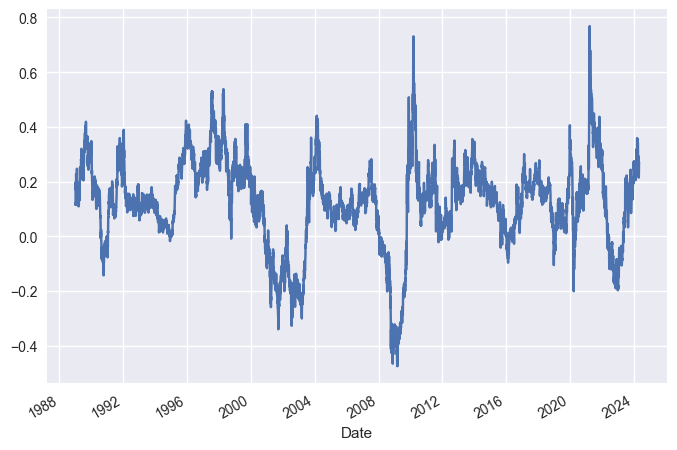

In [75]:
# ASSET AND DATA
# get market data (here S&P500 used as a golden standard for a potential investment)
# the market doesn't have 365 days
# If you chose another asset the market days value in a year can be different
# download the annual return of the chosen financial instrument
asset = "^SP500TR"
year_market_days = 253
df = yf.download(asset)["Adj Close"].pct_change(year_market_days).dropna()
df.plot()

In [76]:
# EARNINGS SECTION: JOB (BARISTA FIRE SCENARIO)
# This first section simulates a life with simultaneous work and investment income.
# It can be used to implement the bartender fire (a fire with a small working side hustle) or
# to simulate the common working lifestyle of a person who invests and has income.
# The expenditure, if greater than the earnings, will be deducted from the investment
# capital as in a fire. If lower, it will be put into the investment simulated account
# as if we are doing a PAC all-in.
# Everything is always scaled down during
# the simulations in proportion to inflation, so it is fine to put the average values of
# today's earnings and expenses.
# So if withdrawal is negative it becomes a deposit (insert payment per month)
avg_net_earnings_job_time = 0
avg_net_expenses_job_time = 800
withdrawal_job_monthly = avg_net_expenses_job_time - avg_net_earnings_job_time
years_job = 15

In [77]:
# EARNINGS SECTION: PENSION RETIREMENT SCENARIO
# Fill in the parameters with expenses and earnings according to today's parameters.
# The adjustment for inflation will be done automatically
avg_net_earnings_retired = 0
avg_net_expenses_retired = 800
withdrawal_retired_monthly = avg_net_expenses_retired - avg_net_earnings_retired
years_retired = 60

In [78]:
withdrawal_job = withdrawal_job_monthly * 12
withdrawal_retired = withdrawal_retired_monthly * 12
sim_years = years_job + years_retired + 1

In [79]:
# MONTECARLO COMBINATIONS
# I will now proceed with a Monte Carlo simulation of the possible combinations of events. I approach them 3 by 3
# since the market (especially that of instruments such as the S&P) has periodic trends between consecutive years (
# after all, if one invests in a very diversified asset there would be little point in an unrealistic simulation that
# accepts combinations that are all extremely positive or all negative until complete default). Doing so increases
# the realism of the forecast by including economic cycles.
simulation_num = 10000
upper = len(df) - 3 * year_market_days - 1
equity_compound_interest_factor = np.zeros((sim_years, simulation_num))
equity_compound_interest_factor[0, :] = 1
equity_current_interest_factor = np.zeros((sim_years, simulation_num))
equity_current_interest_factor[0, :] = 1
for simulation in range(simulation_num):
    for sim_year in range(1, sim_years, 3):
        extracted_rand_earning1 = random.randint(0, upper)
        extracted_rand_earning2 = extracted_rand_earning1 + year_market_days
        extracted_rand_earning3 = extracted_rand_earning2 + year_market_days
        # print(sim_year,simulation)
        if sim_year < sim_years:
            equity_compound_interest_factor[sim_year, simulation] = 1 + df.iloc[extracted_rand_earning1]
            equity_current_interest_factor[sim_year, simulation] = equity_current_interest_factor[sim_year - 1, simulation] * (1 + df.iloc[extracted_rand_earning1])
        if sim_year + 1 < sim_years:
            equity_compound_interest_factor[sim_year + 1, simulation] = 1 + df.iloc[extracted_rand_earning2]
            equity_current_interest_factor[sim_year + 1, simulation] = equity_current_interest_factor[sim_year, simulation] * (1 + df.iloc[extracted_rand_earning2])
        if sim_year + 2 < sim_years:
            equity_compound_interest_factor[sim_year + 2, simulation] = 1 + df.iloc[extracted_rand_earning3]
            equity_current_interest_factor[sim_year + 2, simulation] = equity_current_interest_factor[sim_year + 1, simulation] * (1 + df.iloc[extracted_rand_earning3])

<Axes: >

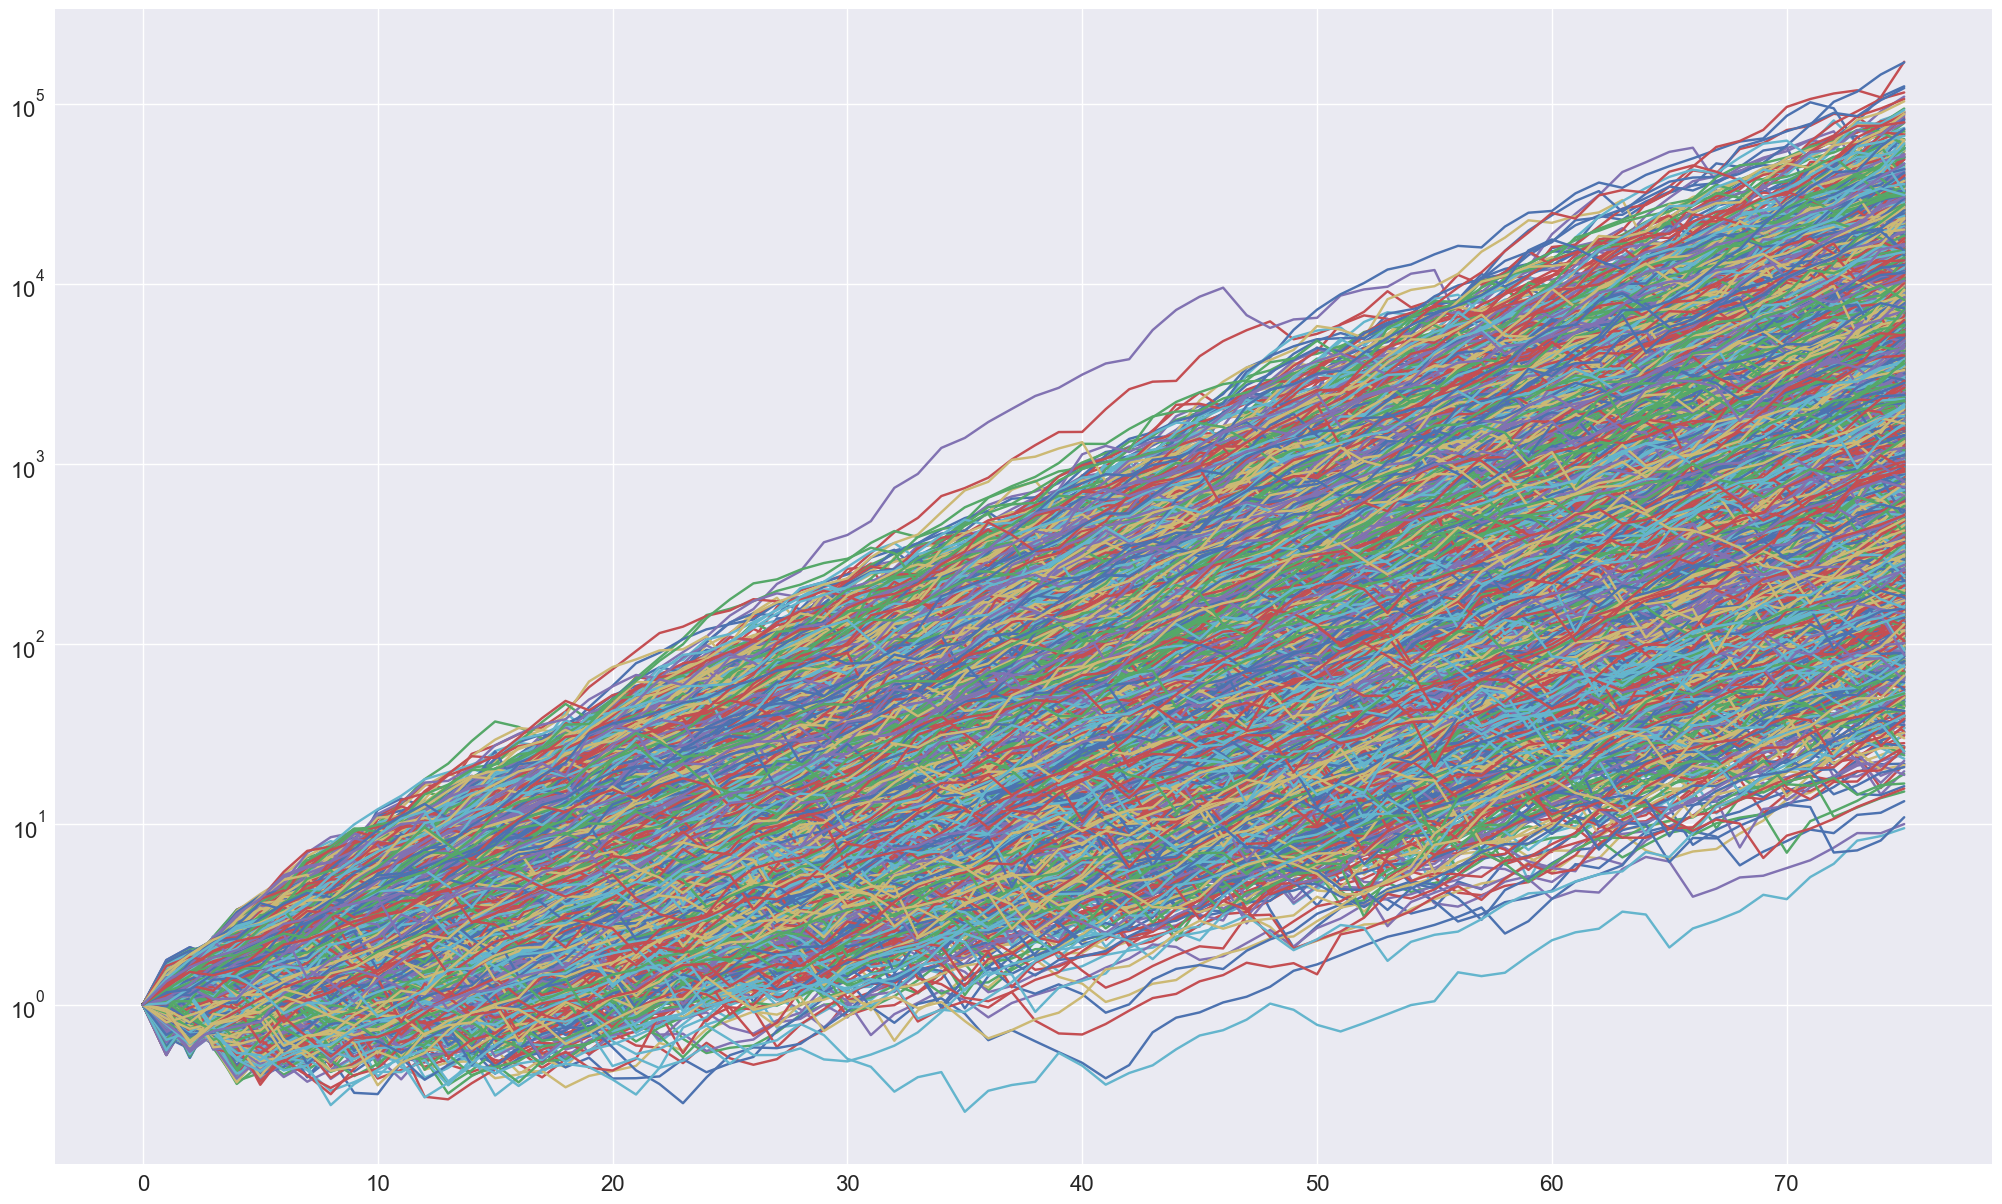

In [80]:
# MONTECARLO COMBINATIONS VISUAL EXTRA
# Optional: you can visualize the simulations of the investment here
pd.DataFrame(equity_current_interest_factor).plot(legend=None,logy=True,fontsize=16,figsize=(25,15))

In [81]:
# INFLATION DATA AND SIMULATION
# Here I include possible multiple simulations of inflation to estimate its very important impact on the estimated
# annual drawdown and the true value of amounts over time.
# I propose several types of estimation

# The possible inputs for the different simulations are:
# "const": inflation is always equal to the average inflation defined here as an editable static parameter
# "real": each year's inflation is rescaled randomly from real data from 1954 to 2022 for Italy
# "real rescaled":
# as above, but is rescaled so that the total average of the vector of years (which would have a historical
# bias from the 1980s that makes it statistically over 5%) is equal to the editable static parameter of
# average inflation (reasonably 3-4% if looking at the data without bias)
# "lognormal": inflation is taken from a lognormal distribution with mean equal to the value of the editable static parameter but with sigma and standard deviation inherited from historical real inflation data ( 0.53 ca.)
inflation_est_mode = "const"
inflation_est_average_fixed = 0.03
inflation_history = np.array(
    [2.3, 3.4, 1.3, 2.8, -0.4, 2.3, 2.1, 4.7, 7.5, 5.9, 4.6, 2.3, 3.7, 1.4, 2.6, 5.0, 4.8, 5.7, 10.8, 19.1, 17.0, 16.8,
     17.0, 12.1, 14.8, 21.2, 17.8, 16.5, 14.7, 10.8, 9.2, 5.8, 4.8, 5.0, 6.3, 6.5, 6.2, 5.3, 4.7, 4.1, 5.3, 4.0, 2.0,
     2.0, 1.7, 2.5, 2.7, 2.5, 2.7, 2.2, 1.9, 2.1, 1.8, 3.3, 0.8, 1.5, 2.7, 3.0, 1.2, 0.2, 0.1, -0.1, 1.2, 1.2, 0.6,
     -0.2, 1.9, 8.1, 8.7]) / 100
if inflation_est_mode == "const":
    inflation = np.ones((sim_years, simulation_num)) * inflation_est_average_fixed
elif inflation_est_mode == "real":
    inflation = inflation_history[np.random.randint(0, len(inflation_history), (sim_years, simulation_num))]
elif inflation_est_mode == "real rescaled":
    inflation = (inflation_history * (inflation_est_average_fixed / inflation_history.mean()))[
        np.random.randint(0, len(inflation_history), (sim_years, simulation_num))]
elif inflation_est_mode == "lognormal":
    mu = np.log(inflation_est_average_fixed)
    sigma = np.log((1 + np.sqrt(1 + 4 * inflation_history.var() / np.exp(2 * mu))) / 2)
    mu = np.log(inflation_est_average_fixed) - sigma ** 2 / 2
    sigma = np.log((1 + np.sqrt(1 + 4 * inflation_history.var() / np.exp(2 * mu))) / 2)
    mu = np.log(inflation_est_average_fixed) - sigma ** 2 / 2
    inflation = np.random.lognormal(mean=mu, sigma=sigma, size=(sim_years, simulation_num))
else:
    print("Unexpected input.\n"
          "String for inflation not present among the options so average inflation will be used here.")
    inflation = np.ones((sim_years, simulation_num)) * inflation_est_average_fixed
print("Inflation Average:", inflation.mean(), "Inflation Std Dev:", inflation.std())
print("Simulated Inflation History:\n", str(inflation))

Inflation Average: 0.029999999999999968 Inflation Std Dev: 3.122502256758253e-17
Simulated Inflation History:
 [[0.03 0.03 0.03 ... 0.03 0.03 0.03]
 [0.03 0.03 0.03 ... 0.03 0.03 0.03]
 [0.03 0.03 0.03 ... 0.03 0.03 0.03]
 ...
 [0.03 0.03 0.03 ... 0.03 0.03 0.03]
 [0.03 0.03 0.03 ... 0.03 0.03 0.03]
 [0.03 0.03 0.03 ... 0.03 0.03 0.03]]


In [82]:
# EXTRA OPTION: INHERITANCE
# Suppose we know that we have non-liquid assets that sooner or later we want to turn into investments.
# One scenario in which this can happen is that sooner or later we will inherit extra assets to our current ones.
# As in real life we cannot know when this might happen, but we can randomise it.
# We can also decide to convert assets we already own at a known time in the future that we can predict
# Enter the value of the asset at today which will then be reasonably adjusted for inflation
# (especially reasonable in the case of a real estate asset)
# This is an extra option for the sake of customisation but in a way it dirties the simulation with
# the Monte Carlo method on pure investment.
# I therefore suggest making initial estimates for a mathematical analysis with the static estate parameter set to 0

# The possible inputs for the different simulations are:
# "random": you collect the inflation-adjusted inheritance amount in a future random year
# "random fixed": as above but with control over the seed.
# In this way the random pick can be made fixed in order to do more simulations with the same number where we may
# want to change the other parameters
# "known": we know we want to invest the amount of an asset of ours corrected for inflation at a future point
# in time that we already know to predict
# All year values represent the relative year as of today (year zero)
estate = 0
seed_num4rand_pick = 4
rand_pick_min_year = 10
rand_pick_max_year = 60
known_pick_year = 25
estate_pick_mode = "None"

if estate_pick_mode == "random":
    year_estate2invest_conversion = random.randint(rand_pick_min_year, rand_pick_max_year)
elif estate_pick_mode == "random fixed":
    random.seed(seed_num4rand_pick)
    year_estate2invest_conversion = random.randint(rand_pick_min_year, rand_pick_max_year)
elif estate_pick_mode == "known":
    year_estate2invest_conversion = known_pick_year
else:
    print("Unexpected input.\n"
          "It will be supposed that no inheritance will be obtained in the future nor in a random year neither "
          "in a known moment.")
    year_estate2invest_conversion = 0
    estate = 0
print(f'You will receive your inheritance in {year_estate2invest_conversion} years.')

Unexpected input.
It will be supposed that no inheritance will be obtained in the future nor in a random year neither in a known moment.
You will receive your inheritance in 0 years.


In [83]:
# BUFFER-LIQUIDITY-BTP and BOND SECTION
# Any savings portfolio rarely has its entire amount in the stock market. Moreover, any withdrawals made from investments are taxed and
# the surplus that would be withdrawn for taxes would also be taxed. Generally one always keeps some liquidity either in bonds or in BTPs
# or in deposit accounts with a good interest rate or in more conservative financial instruments which generally on average over the long
# term yield as much as inflation takes away or slightly more and which are subject to lower or no taxes. For simplicity, let us assume
# that we have an interest on the buffer account equal to inflation and pay taxes by deducting the money from the buffer.
# The buffer account has 2 positive purposes therefore:
# - simplify and improve payments
# - provide money during negative market periods to avoid withdrawing from the account with more long-term growth potential
# However, the buffer account has a negative aspect:
# - you have money invested in lower long-term average returns and for small initial capitals the oversized buffer has a huge negative
# weight on the probability of financial survival
# 1) The buffer is reduced by the fees due for withdrawals (and for withdrawals themselves under the conditions mentioned above) each year
# 2) In each year with positive returns it is replenished up to the predetermined saturation point
# 3) The predetermined saturation point is expressed by the following variable representing the number of equivalent years of withdrawal
# you want to set aside.
# If I enter 2 and annually set aside 10k the financial buffer will saturate and be initialised by deducting from the total capital
# 2*10k = 20k
years_equivalent_equity_buffer = 3

In [84]:
# TAXES AND COSTS SECTION
# - In Italy, stamp duty is payable on all types of financial instruments held, currently at the rate of 2 per mille on an annual basis.
# The basis for calculating the taxable value is the reference price of the securities as recorded on the last day of the tax period.
# - Italy's investment rate is instead taxed at 26% of the capital gain in the stock market.
# Change the value depending on the taxation of the country of residence and the financial instrument chosen
# - A third fractional parameter is intended to allow us to simulate an initial capital that is not liquid but from assets that will be subject
# to taxation before being redeemed and placed as an initial investment (if, for example, we have 100K of capital in a BTP taxed at 12.5%,
# the fraction that allows us to calculate the real value is (100-12.5)/100).
# It is a completely optional parameter.
# Leave 1.0 meaning 100% for the first simulations for convenience.
stamp_duty = 0.002
inv_tax = 0.26
starting_equity_fraction = 1.0  # percentuale che il capitale è costato

<Axes: >

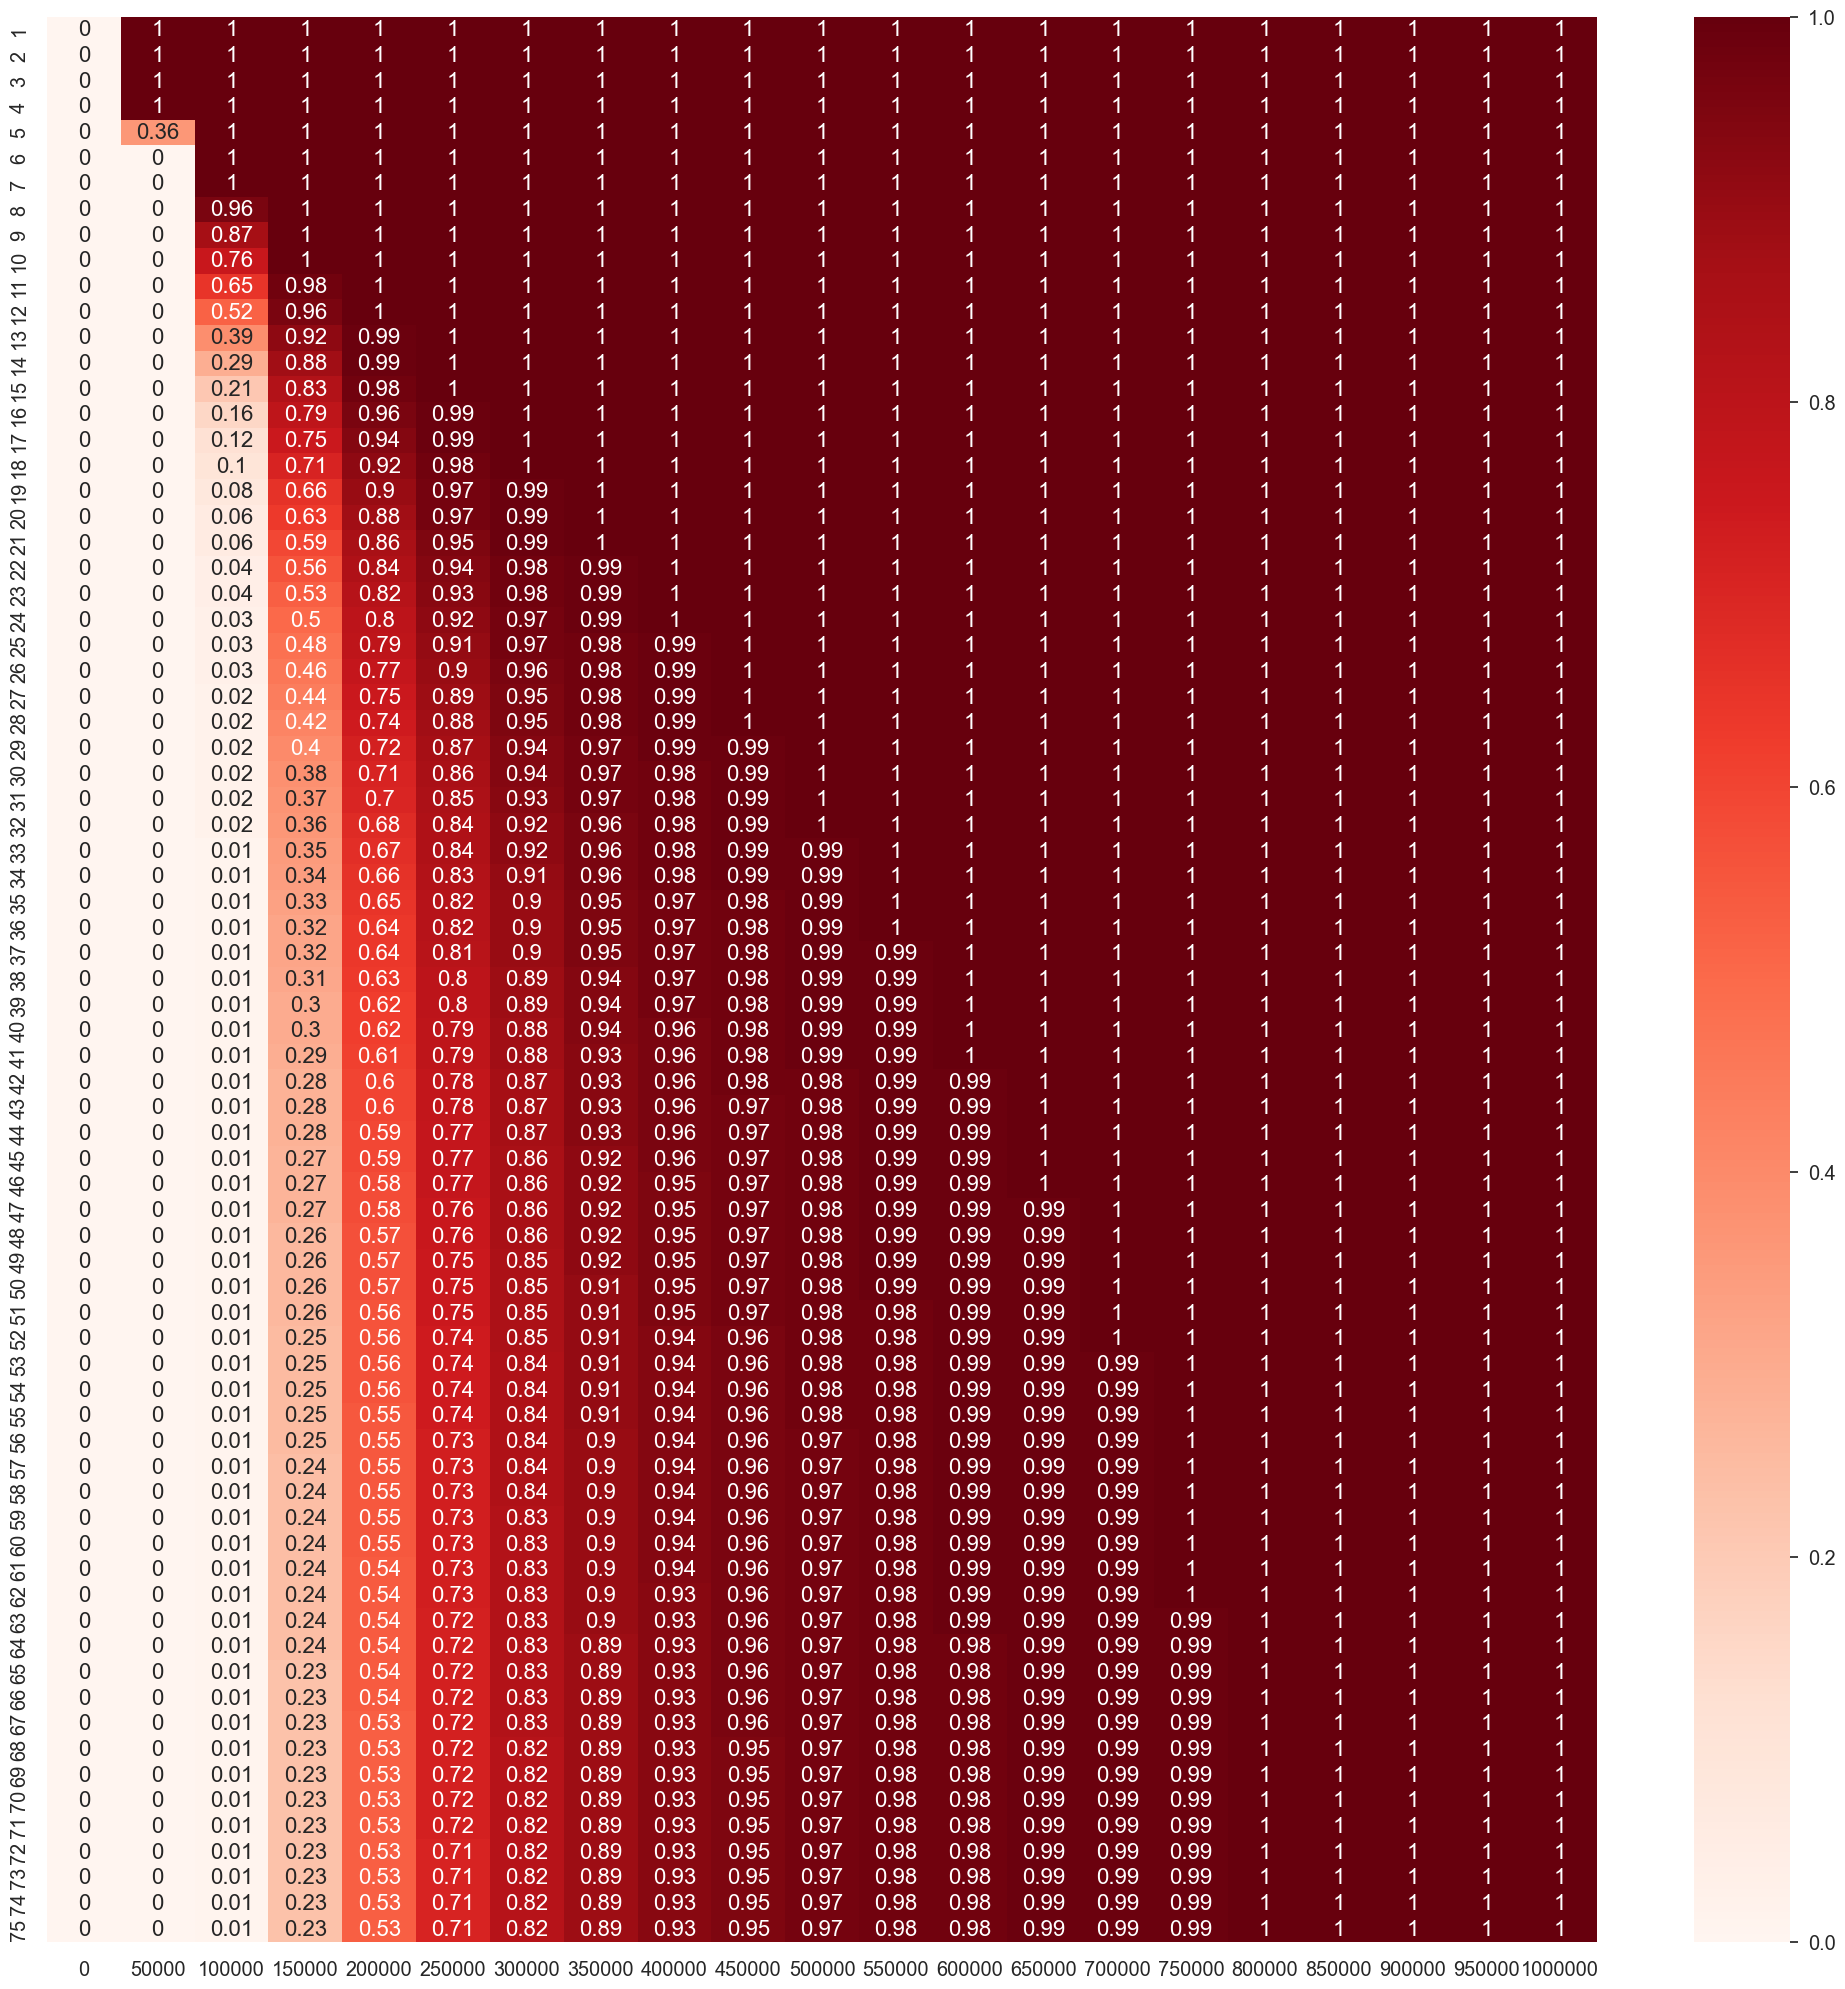

In [90]:
# COMPUTATION SECTION
# I simulate all possible initial capitals from 0 to 1mln with 50k step and see for each year the probability of financial survival given
# the settings made so far

def safe_divide(numerator, denominator, _epsilon=1e-6):
    """
    Performs safe division to avoid dividing by zero.
    Replace values of the denominator that are too small with epsilon

    Args:
    numerator (np.array): Array containing the numerators.
    denominator (np.array): Array containing the denominators.
    epsilon (float): A small value to prevent division by zero.

    Returns:
    np.array: Result of the division.
    """
    safe_denominator = np.where(abs(denominator) < _epsilon, np.copysign(_epsilon, denominator), denominator)
    return numerator / safe_denominator

def manage_financials(desired_equity_buffers, actual_equity_buffers, _fire_cum_equities, _withdrawals, _capital_gains, _inv_tax):
    """
    Manages investments and buffers after calculating taxes on the money rearrangement.

    Parameters:
    - _year (int): The current year of the simulation.
    - desired_equity_buffers (numpy.ndarray): 2D array representing the desired buffer states before adjustments.
    - actual_equity_buffers (numpy.ndarray): 2D array representing the actual buffer states after financial operations.
    - _fire_cum_equities (numpy.ndarray): 2D array containing cumulative equities for each year and simulation.
    - _withdrawals (numpy.ndarray): 2D array containing planned withdrawal amounts for each year and simulation.
    - _capital_gains (numpy.ndarray): 1D array containing capital gains for each simulation.
    - _inv_tax (float): Tax rate on investments.
    - _epsilon (float): Threshold value used to avoid division by zero.
    - new_buffers (numpy.ndarray): Precomputed new buffer values for the current year, used to determine withdrawals.

    Returns:
    - actual_equity_buffers (numpy.ndarray): Updated 2D array with financial buffers after withdrawals and taxes.
    - _fire_cum_equities (numpy.ndarray): Updated 2D array with cumulative equities after withdrawals.
    - _capital_gains (numpy.ndarray): Updated 1D array of capital gains after tax application.

    Description:
    The function uses the provided desired equity buffer values to determine the actual amount to withdraw from the investments
    account, ensuring it is not negative. This happens whenever the money needed for withdrawals must be transferred in the
    buffer/cash account:
    - When the asset annual returns are positive
    - When there are not enough money available for withdrawals in the current year
    - When the buffer must be set at the very beginning with the expected withdrawals amount
    It calculates applicable taxes if the withdrawal amount is positive and the savings in the investment account aren't already
    depleted and updates the capital gains by reducing them proportionally based on the taxable amount.
    Finally, updates the investment equities and buffers with net values after withdrawals and taxes.
    """
    withdrawals_amount = np.maximum(0, desired_equity_buffers - actual_equity_buffers)
    _taxes = np.where(_fire_cum_equities * withdrawals_amount > 0,
                     withdrawals_amount * (1 - safe_divide(_capital_gains, _fire_cum_equities)) * _inv_tax,
                     0)
    _capital_gains = np.where(_taxes == 0,
                              _capital_gains,
                              _capital_gains * (1 - safe_divide(withdrawals_amount, _fire_cum_equities)))
    _fire_cum_equities = _fire_cum_equities - withdrawals_amount
    actual_equity_buffers = actual_equity_buffers + withdrawals_amount - _taxes
    return actual_equity_buffers, _fire_cum_equities, _capital_gains



epsilon = 1e-6
starting_equities = list(range(0, 1000001, 50000))
summaryTable = pd.DataFrame(np.zeros((years_job + years_retired, len(starting_equities))),
                            columns=starting_equities,
                            index=list(range(1, sim_years)))
withdrawals = np.zeros((sim_years, simulation_num))


# The first year each month I withdraw what was declared at work
withdrawals[0, :] = withdrawal_job
# Create the inflation coefficient vector taking into account the compound mutual interest
inflation_compound_interest_factor = np.ones(simulation_num)
for year in range(1, years_job + 1):
    withdrawals[year, :] = withdrawals[year - 1, :] * (1 + inflation[year, :])
    inflation_compound_interest_factor = inflation_compound_interest_factor * (1 + inflation[year, :])

# Create the vector of actual withdrawals considering the compound interest of inflation
withdrawals[years_job + 1] = withdrawal_retired * inflation_compound_interest_factor * (1 + inflation[years_job + 1, :])
for year in range(years_job + 2, sim_years):
    withdrawals[year, :] = withdrawals[year - 1, :] * (1 + inflation[year, :])

for starting_equity in starting_equities:
    buffers = np.zeros((sim_years, simulation_num))
    fire_cum_equities = np.zeros((sim_years, simulation_num))
    capital_gains = np.ones(simulation_num) * starting_equity_fraction * starting_equity

    # Simulate the first year separately due to the initialization of buffers
    year = 0
    fire_cum_equities[0, :] = starting_equity

    # Create the equity buffer based on how many equivalent years of spending I want to have in the buffer account without exceeding the threshold of the maximum
    # initial capital that I am simulating in the current iteration
    # In the first year, I always make withdrawals, so if the years for the equity buffer are set to a value less than 1 by mistake or to put
    # 0, they are set to 1
    # I then simulate that the money is taken from the investment account and taxed for the amount withdrawn in proportion to the capital gains
    # (initially none, but I use the same function always even though the tax calculation in this sense is not needed in the first year so it's as
    # if I created the necessary account for the buffer directly and took the equivalent of the buffer from the investment fund in order to have
    # a total amount equal to the simulation capital)
    new_buffers = np.minimum(fire_cum_equities[year, :] + buffers[year, :],
                             withdrawals[year, :] * max(years_equivalent_equity_buffer, 1))
    buffers[year, :], fire_cum_equities[year, :], capital_gains = manage_financials(
    desired_equity_buffers=new_buffers,
    actual_equity_buffers=buffers[year, :],
    _fire_cum_equities=fire_cum_equities[year, :],
    _withdrawals=withdrawals[year, :],
    _capital_gains=capital_gains,
    _inv_tax=inv_tax
    )
    # The withdrawal is then executed.
    # If there is no need to withdraw because the personal balance is positive, the buffer remains as is and the gain is added to the
    # investments as if it were a systematic investment plan
    # Finally Rounding errors on investment funds that went default are corrected by setting them to 0.
    buffers[year, :] = np.where(withdrawals[year, :] >= 0,
                                buffers[year, :] - withdrawals[year, :],
                                buffers[year, :])
    fire_cum_equities[year, :] = np.where(withdrawals[year, :] >= 0,
                                          fire_cum_equities[year, :],
                                          fire_cum_equities[year, :] - withdrawals[year, :])
    fire_cum_equities[year, :] = np.where(fire_cum_equities[year, :] < withdrawals[year, :] * epsilon, 0,
                          fire_cum_equities[year, :])
    # Simulate the remaining years
    for year in range(1, sim_years):
        # The previous year ends, and the portfolio value is updated based on the simulated returns and losses of the asset
        # The previous year ends, and the value of the buffer is increased in line with inflation as is usual with the interest
        # of a deposit account or conservative bonds
        # Stamp duty is paid
        fire_cum_equities[year, :] = fire_cum_equities[year - 1, :] * equity_compound_interest_factor[year, :]
        buffers[year, :] = buffers[year, :] * (1 + inflation[year, :])
        buffers[year, :] = buffers[year - 1, :] - (fire_cum_equities[year, :] + buffers[year - 1, :]) * stamp_duty
        # The buffer, which may have been reduced by withdrawals in the previous cycle, needs to be replenished
        # This is done only if there were positive returns that were higher than the previous year
        # This caution improves the long-term performance of the portfolio during market crash scenarios
        new_buffers = np.where(equity_current_interest_factor[year, :] > np.maximum(equity_current_interest_factor[year - 1, :], 0),
                              np.minimum(fire_cum_equities[year, :] + buffers[year, :],
                                         withdrawals[year, :] * years_equivalent_equity_buffer),
                                         buffers[year, :])
        buffers[year, :], fire_cum_equities[year, :], capital_gains = manage_financials(
        desired_equity_buffers=new_buffers,
        actual_equity_buffers=buffers[year, :],
        _fire_cum_equities=fire_cum_equities[year, :],
        _withdrawals=withdrawals[year, :],
        _capital_gains=capital_gains,
        _inv_tax=inv_tax
        )
        # Given the stringent conditions with which the buffer is replenished, there can be prolonged lean periods or excessive withdrawals
        # Therefore, the buffer can reduce well beyond the value of equivalent years until it is no longer able to support withdrawals
        # for a single year.
        # In such cases, it is necessary to replenish the buffer for at least one year's withdrawals as long as capital is available.
        new_buffers = np.minimum(fire_cum_equities[year, :] + buffers[year, :], np.maximum(buffers[year, :], withdrawals[year, :]))
        buffers[year, :], fire_cum_equities[year, :], capital_gains = manage_financials(
        desired_equity_buffers=new_buffers,
        actual_equity_buffers=buffers[year, :],
        _fire_cum_equities=fire_cum_equities[year, :],
        _withdrawals=withdrawals[year, :],
        _capital_gains=capital_gains,
        _inv_tax=inv_tax
        )
        # The withdrawal is then executed.
        # If there is no need to withdraw because the personal balance is positive, the buffer remains as is and the gain is added to the
        # investments as if it were a systematic investment plan
        # It is also checked if the current year coincides with the year of conversion of the inheritance into investments.
        # The amount of the inheritance is then added to the buffers after executing the scheduled withdrawal for the year.
        # Otherwise, the normal scheduled withdrawal is performed without additions.
        # In principle, if this were to happen in reality, it would be advisable to put the value of the inheritance directly among the investments
        # with an average interest higher than that of the buffer
        # Finally Rounding errors on investment funds that went default are corrected by setting them to 0.
        if year == year_estate2invest_conversion:
            buffers[year, :] = np.where(withdrawals[year, :] >= 0, buffers[year, :] - withdrawals[year, :] + estate, buffers[year, :] + estate)
        else:

            buffers[year, :] = np.where(withdrawals[year, :] >= 0, buffers[year, :] - withdrawals[year, :], buffers[year, :])

        fire_cum_equities[year, :] = np.where(withdrawals[year, :] >= 0, fire_cum_equities[year, :], fire_cum_equities[year, :] - withdrawals[year, :])
        fire_cum_equities[year, :] = np.where(fire_cum_equities[year, :] < withdrawals[year, :] * 1e-6, 0,
                              fire_cum_equities[year, :])

    for sim_year in range(1, sim_years):
        summaryTable.loc[[sim_year], [starting_equity]] = round(((fire_cum_equities[sim_year, :] + buffers[sim_year, :]) >= 0).mean(), 2)

plt.figure(figsize=(25, 25))
seaborn.set(font_scale=1.3)
seaborn.heatmap(summaryTable, cmap="Reds", annot=True, annot_kws={"size": 16})